In [1]:
import os
import json
import torch
from IPython.display import HTML, display
from tqdm import tqdm
from datasets import load_dataset
from transformer_lens import HookedTransformer
import transformer_lens.utils as tutils
import matplotlib
import matplotlib.pyplot as plt

from config import SAEConfig
from model import SparseAutoencoder

torch.set_grad_enabled(False)


/Users/slava/safety/sae_drill/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoint_dir = "checkpoints/2024-04-13_12-30-52"  # expansion factor = 8
# checkpoint_dir = "checkpoints/2024-04-13_14-10-45"  # expansion factor = 16

with open(os.path.join(checkpoint_dir, "config.json")) as f:
    cfg = json.load(f)
cfg = SAEConfig(**cfg)
cfg.device = "cuda" if torch.cuda.is_available() else "cpu"

print("expansion factor:", cfg.expansion_factor)

sae = SparseAutoencoder(cfg)
sae.load_state_dict(torch.load(os.path.join(checkpoint_dir, "final_model.pt"), map_location=torch.device(cfg.device)))

model = HookedTransformer.from_pretrained(cfg.model_name, device=cfg.device)

hook_point = cfg.hook_point.format(layer=cfg.hook_point_layer)


Run name: 4096-L1-0.0002-LR-0.0003
expansion factor: 8
Loaded pretrained model gelu-2l into HookedTransformer


In [3]:
# load large sae
large_checkpoint = "checkpoints/2024-04-13_14-10-45"  # expansion factor = 16
with open(os.path.join(large_checkpoint, "config.json")) as f:
    l_cfg = json.load(f)
l_cfg = SAEConfig(**l_cfg)
l_cfg.device = "cuda" if torch.cuda.is_available() else "cpu"

print("expansion factor:", l_cfg.expansion_factor)

large_sae = SparseAutoencoder(l_cfg)
large_sae.load_state_dict(torch.load(os.path.join(large_checkpoint, "final_model.pt"), map_location=torch.device(l_cfg.device)))


Run name: 8192-L1-0.0002-LR-0.0003
expansion factor: 16


<All keys matched successfully>

In [4]:
data = load_dataset("NeelNanda/c4-code-20k", split="train")

tokenized_data = tutils.tokenize_and_concatenate(data, model.tokenizer, max_length=128)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [5]:
def dla(sae_model, model, feature_id, top_n=10):
    # Direct logit attribution
    logit_attributions = sae_model.W_dec[feature_id] @ model.W_U

    top_idxs = torch.argsort(logit_attributions, descending=True)[:top_n]
    bottom_idxs = torch.argsort(logit_attributions, descending=False)[:top_n]
    top_tokens = [model.to_string([idx.item()]) for idx in top_idxs]
    bottom_tokens = [model.to_string([idx.item()]) for idx in bottom_idxs]

    print(f"feature id: {feature_id} \n")
    print('top')
    print(top_tokens)
    print(logit_attributions[top_idxs])
    print('bottom')
    print(bottom_tokens)
    print(logit_attributions[bottom_idxs])

def get_feature_acts(feature_id, batch_size, n_batches, sae_model):
    tokens = all_tokens[:batch_size*n_batches]
    all_acts = []
    for i in tqdm(range(n_batches)):
        batch = tokens[i*batch_size:(i+1)*batch_size]
        _, cache = model.run_with_cache(batch,
                                        stop_at_layer=cfg.hook_point_layer + 1,
                                        names_filter=[hook_point],
                                    )
        in_acts = cache[hook_point]
        in_acts = in_acts.reshape(-1, cfg.d_in)
        sae_out, feature_acts, loss, mse_loss, l1_loss = sae_model(in_acts)

        feature_acts = feature_acts[:, feature_id].detach().cpu()
        all_acts.append(feature_acts)
        
    all_acts = torch.cat(all_acts, dim=0)
    return all_acts, tokens

def single_neuron(tokens: torch.Tensor, acts: torch.Tensor, ft_id, model, top_n=10):
    # taken from my sparse distillation code.
    # tokens and acts shapes are both (n_examples, len_example)
    max_acts = acts.max(dim=1)
    sorted_top_indices = torch.argsort(max_acts.values, descending=True)[:top_n]

    # Process only the top_n activations and corresponding tokens
    snippets = []
    for idx in sorted_top_indices:
        snippet = {}
        example = tokens[idx]
        snippet["text"] = model.to_string(example)
        snippet["max_activation"] = float(acts[idx].max())
        snippet["token_activation_pairs"] = [
            [
                model.to_string(example[j]).replace(" ", "·")
                                                      .replace("\n", "↩" + "\n")
                                                      .replace("\t", "→"),
                float(acts[idx, j])
            ]
            for j in range(example.shape[0])
        ]
        snippets.append(snippet)

    res = {
        "neuron_id": str(ft_id),
        "snippets": snippets
    }
    return res

def style_snippet(snippet_idx, act_data):
    tokens_with_activations = act_data['snippets'][snippet_idx]["token_activation_pairs"]
    max_act = act_data['snippets'][snippet_idx]["max_activation"]
    
    # Function to map activation to color
    def activation_to_color(activation):
        if activation < 0:
            return '#FFFFFF'
        normalized_activation = activation / max_act*0.6
        return plt.cm.Reds(normalized_activation)
    
    styled_text = ''.join(f'<span style="background-color: {matplotlib.colors.rgb2hex(activation_to_color(activation))}; margin-right: 0px;">{token}</span>'
                          for token, activation in tokens_with_activations)
    return styled_text

def display_acts(feature_id, sae_model):
    dla(sae_model, model, feature_id=feature_id)

    feature_acts, tokens = get_feature_acts(feature_id=feature_id, batch_size=256, n_batches=10, sae_model=sae_model)
    act_data = single_neuron(tokens=tokens, acts=feature_acts.reshape(-1, 128), ft_id=feature_id, model=model)

    print("feature id: ", feature_id)
    print()
    for i, snippet in enumerate(act_data['snippets']):
        styled_text = style_snippet(i, act_data)
        snippet_info = f'<div style="word-wrap: break-word; margin-bottom: 10px;"><strong>Snippet number:</strong> {i}<br><strong>Max activation:</strong> {snippet["max_activation"]}<br>{styled_text}</div>'
        display(HTML(snippet_info))
    


In [6]:
feature_id = 3
display_acts(feature_id=feature_id, sae_model=sae)

feature id: 3 

top
['ically', 'mund', 'gered', ' analytics', 'uez', 'mond', ' Analytics', ' analysis', 'tes', ' paralysis']
tensor([0.8503, 0.7261, 0.7139, 0.6627, 0.6458, 0.6364, 0.6274, 0.6072, 0.6072,
        0.6041])
bottom
['ridge', 'worth', 'birth', 'mates', 'numbered', 'ido', 'ities', 'ridges', 'ward', 'issance']
tensor([-0.7225, -0.6403, -0.6209, -0.6063, -0.5930, -0.5912, -0.5891, -0.5780,
        -0.5780, -0.5693])


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]

feature id:  3



In [7]:
def find_cosine_sim(enc_vec, W_enc):
    sims = torch.cosine_similarity(enc_vec.unsqueeze(0), W_enc.T, dim=1)

    top_idxs = torch.argsort(sims, descending=True)[:10]
    print('top_idxs:', top_idxs)
    print('sims:', sims[top_idxs])


find_cosine_sim(sae.W_enc[:, feature_id], sae.W_enc)


top_idxs: tensor([   3, 1284, 1939, 3759, 3701,  770,  487, 2172, 1131, 1031])
sims: tensor([1.0000, 0.6679, 0.6557, 0.6517, 0.6503, 0.6497, 0.6487, 0.6474, 0.6446,
        0.6437])


In [8]:
print('similarity of small_sae vec to large_sae\n')
find_cosine_sim(sae.W_enc[:, feature_id], large_sae.W_enc)

similarity of small_sae vec to large_sae

top_idxs: tensor([ 164, 3716, 4259, 1834, 1477, 7468,   72, 8005,  997, 3945])
sims: tensor([0.7534, 0.6981, 0.6898, 0.6887, 0.6786, 0.6782, 0.6766, 0.6764, 0.6758,
        0.6757])


In [9]:
display_acts(feature_id=7468, sae_model=large_sae)

feature id: 7468 

top
[' namely', ' which', ' albeit', ' respectively', ' thereby', ' wherein', ' but', ' however', ' huh', ' although']
tensor([0.6792, 0.6532, 0.6270, 0.6168, 0.6120, 0.6038, 0.5933, 0.5739, 0.5726,
        0.5726])
bottom
['ano', 'ington', ',', 'oton', 'lich', 'nes', ',*', 'ieurs', 'oter', 'ardon']
tensor([-0.5075, -0.4882, -0.4835, -0.4748, -0.4723, -0.4681, -0.4669, -0.4651,
        -0.4627, -0.4610])


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]

feature id:  7468



In [10]:
find_cosine_sim(large_sae.W_enc[:, 164], large_sae.W_enc)

top_idxs: tensor([ 164,  997, 3367, 4853, 5804, 3571, 7468, 1477, 4259, 5073])
sims: tensor([1.0000, 0.6456, 0.6445, 0.6432, 0.6418, 0.6379, 0.6361, 0.6342, 0.6315,
        0.6310])


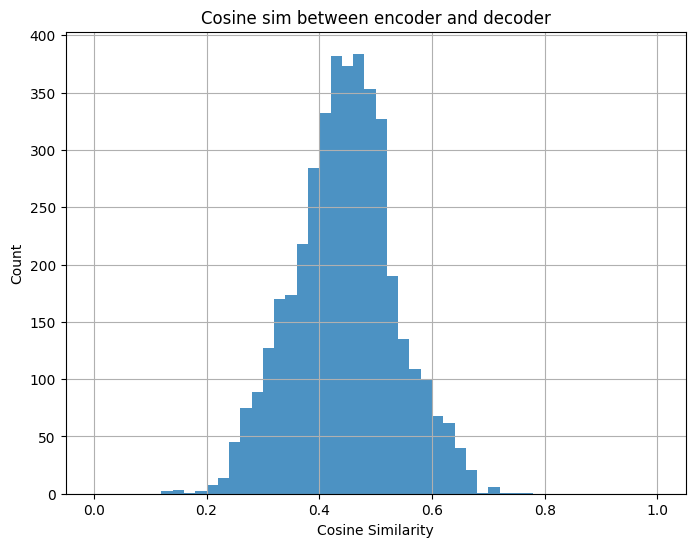

In [15]:
def enc_dec_cosine_sims(sae):
    cosine_sims = []
    for i in range(sae.W_enc.shape[1]):
        enc_vec = sae.W_enc[:, i]
        dec_vec = sae.W_dec[i, :]
        cosine_sims.append(torch.cosine_similarity(enc_vec, dec_vec, dim=0).item())
    return cosine_sims

plt.figure(figsize=(8, 6))
plt.hist(enc_dec_cosine_sims(sae), bins=50, range=(0, 1), alpha=0.8)
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.title('Cosine sim between encoder and decoder')
plt.grid(True)
plt.show()

[0.6888646483421326, 0.6611109375953674, 0.650036633014679, 0.635138213634491, 0.6932141184806824, 0.6442002654075623, 0.6610358953475952, 0.6734133958816528, 0.6823070049285889, 0.6558814644813538, 0.6641765236854553, 0.6832172274589539, 0.6531399488449097, 0.7055886387825012, 0.6672194600105286, 0.6540794372558594, 0.673988401889801, 0.6616364121437073, 0.6715394258499146, 0.6931456327438354, 0.6433504819869995, 0.6280264854431152, 0.6385133862495422, 0.6558743715286255, 0.6331278085708618, 0.6828550100326538, 0.6681339144706726, 0.6685584783554077, 0.6643867492675781, 0.6562178134918213, 0.6614547967910767, 0.6891798973083496, 0.6442199349403381, 0.6679375171661377, 0.669519305229187, 0.6509300470352173, 0.6469013094902039, 0.635186493396759, 0.6459383368492126, 0.6928415894508362, 0.6401245594024658, 0.6607586145401001, 0.6349854469299316, 0.6741006970405579, 0.6474357843399048, 0.672457218170166, 0.6628548502922058, 0.6704386472702026, 0.6625187397003174, 0.6635229587554932, 0.668

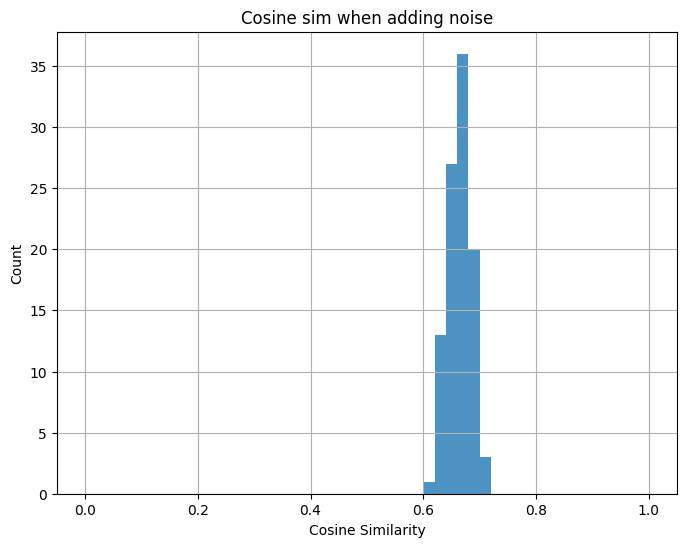

In [28]:
def sims_for_noise_level(d_model: int = 512, n_samples: int = 100, noise_scale=0.01):
    sims = []
    base_vec = torch.ones(d_model)
    base_vec = base_vec / base_vec.norm(p=2, dim=0)

    for _ in range(n_samples):
        noised_vec = base_vec + torch.randn_like(base_vec) * noise_scale
        sims.append(torch.cosine_similarity(base_vec, noised_vec, dim=0).item())
    average = sum(sims) / len(sims)
    return sims, average

sims, av = sims_for_noise_level(noise_scale=0.05)
print(sims)
plt.figure(figsize=(8, 6))
plt.hist(sims, bins=50, range=(0, 1), alpha=0.8)
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.title('Cosine sim when adding noise')
plt.grid(True)
plt.show()


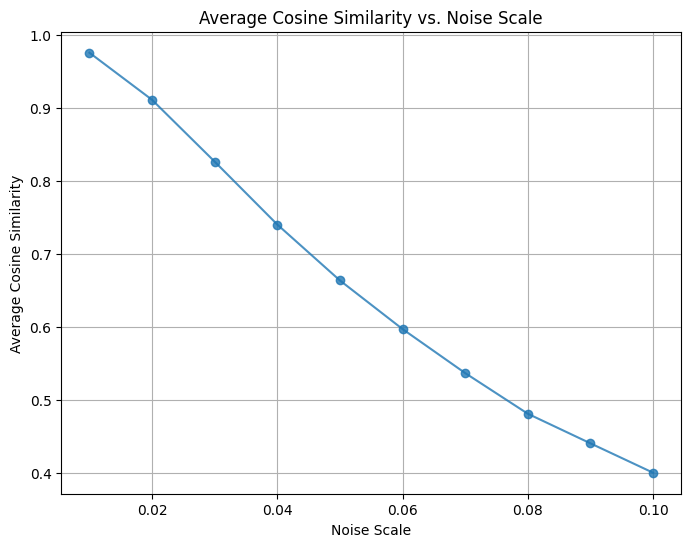

In [32]:
noise_scales = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
avg_sims = [sims_for_noise_level(noise_scale=scale)[1] for scale in noise_scales]

plt.figure(figsize=(8, 6))
plt.plot(noise_scales, avg_sims, marker='o', linestyle='-', alpha=0.8)
plt.xlabel('Noise Scale')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity vs. Noise Scale')
plt.grid(True)
plt.show()